# Phase 4 Project Submission¶
- Student name: Lucas Wilkerson
- Student pace: Flex/part time
- Scheduled project review date/time:
- Instructor name: Morgan Jones

# Pneumonia Detection and Classification

## Project Overview

For this project, the aim is to build a model for image classification that can classify whether a patient has pneumonia when provided a chest x-ray image. 

## Business Problem and Stakeholder

A healthcare physician group is looking to improve their patient outcomes, specifically patients who are being diagnosed with pneumonia. Pneumonia is a significant health concern among patients, especially geriatric and pediatric patients. For effective treatment and the best possible outcomes, early detection and diagnosis is crucial. Current methods for diagnosing pneumonia can be time-consuming and can be prone to error. Through the development and use of method such as image classification and deep learning, we may be able to improve this process which can lead to an increase in early accurate identification and as a result improve patient outcomes.


## Data Understanding

The dataset used for this project contains chest X-ray images from pediatric patients with or without pneumonia who are ages one to five. The dataset is already separated and organized into three groups:

- Train: data used for training the model
- Test: data used for testing and evaluating the model's performance 
- Validation: data used during the training process to help tune the model



## Data Preparation/ Preprocessing

To start the preparation and preprocessing phase, the necessary packages will be imported for this project. Next a directory path will be made to each of the three dataset groups: training data, test data, validation data. The images will be loaded and also rescaled. 


In [29]:
#importing necessary packages

from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from sklearn.utils import class_weight , compute_class_weight
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import tensorflow as tf
from keras import datasets, layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Activation
from keras import optimizers 
from keras.optimizers import Adam , SGD, RMSprop
from keras.metrics import Accuracy, Recall
from keras.utils import array_to_img, img_to_array, load_img
from keras import regularizers
from keras.regularizers import l1 , l2 
from keras.callbacks import EarlyStopping
import os

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
os.environ['KMP_DUPLICATE_LIB_OK']='True' # This prevents kernel shut down due to xgboost conflict
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # This line prevents tf's comments about the optimizing your machine


In [5]:
# Creating directory path for loading datasets
train_dir = 'chest_xray/train/'
test_dir = 'chest_xray/test/'
val_dir = 'chest_xray/val/'

In [6]:
# Function to get the number of images in each directory
def get_directory_counts(directory):
    directory_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            directory_counts[class_name] = num_images
    return directory_counts

# Get the number of images in each directory for train, test, and validation directories
train_directory_counts = get_directory_counts('chest_xray/train')
test_directory_counts = get_directory_counts('chest_xray/test')
val_directory_counts = get_directory_counts('chest_xray/val')

# Print the results
print("Train Directory Counts:", train_directory_counts)
print("Test Directory Counts:", test_directory_counts)
print("Validation Directory Counts:", val_directory_counts)


Train Directory Counts: {'PNEUMONIA': 3875, 'NORMAL': 1341}
Test Directory Counts: {'PNEUMONIA': 390, 'NORMAL': 234}
Validation Directory Counts: {'PNEUMONIA': 8, 'NORMAL': 8}


In [7]:
# Performing data augmentmentation to increase data diversity and possibly mitigate some effects of class imbalance
# All images will be rescaled by 1./255


# Set the seed for reproducibility
np.random.seed(42)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


# Getting all training data (5216 images) 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        batch_size=5216, 
        class_mode='binary')

# Getting all the test data (624 images)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        batch_size=624,
        class_mode='binary')


# Getting all the validation data (16 images)
val_generator = val_datagen.flow_from_directory(
        val_dir,
        batch_size=16, 
        class_mode='binary')

# Creating the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Data Analysis/ Data Visualization

In [8]:
# Function to get class counts
def get_class_counts(labels):
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    class_counts_dict = dict(zip(unique_classes, class_counts))
    return class_counts_dict

# Get class counts for each dataset
train_class_counts = get_class_counts(train_labels)
test_class_counts = get_class_counts(test_labels)
val_class_counts = get_class_counts(val_labels)

# Print class counts
print("Train Class Counts:", train_class_counts)
print("Test Class Counts:", test_class_counts)
print("Validation Class Counts:", val_class_counts)

# Viewing class indices
train_generator.class_indices


Train Class Counts: {0.0: 1341, 1.0: 3875}
Test Class Counts: {0.0: 234, 1.0: 390}
Validation Class Counts: {0.0: 8, 1.0: 8}


{'NORMAL': 0, 'PNEUMONIA': 1}

In [9]:
# Previewing shape of each dataset

print("Image Dataset Shape")
print("Train:", train_images.shape)
print("Test:", test_images.shape)
print("Validation:", val_images.shape)

print("Label Dataset Shape")
print("Train:", train_labels.shape)
print("Test:", test_labels.shape)
print("Validation:", val_labels.shape)



Image Dataset Shape
Train: (5216, 256, 256, 3)
Test: (624, 256, 256, 3)
Validation: (16, 256, 256, 3)
Label Dataset Shape
Train: (5216,)
Test: (624,)
Validation: (16,)


Looking at the characteristics of the datasets, we can derive the total number of images per group, along with the size of each image, and the class indices for labeling. Images labeled with a 0 are classified as Normal while images labeled with a 1 are classified as having Pneumonia. 

Training set: 5216 images 
- Pneumonia: 3875
- Normal: 1341

Test set: 624 images 
- Pneumonia: 390
- Normal: 234

Validation set: 16 images
- Pneumonia: 8
- Normal: 8

Image size: 256 x 256 x 3


In [10]:
train_labels[:20]

array([1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 1.], dtype=float32)

0.0


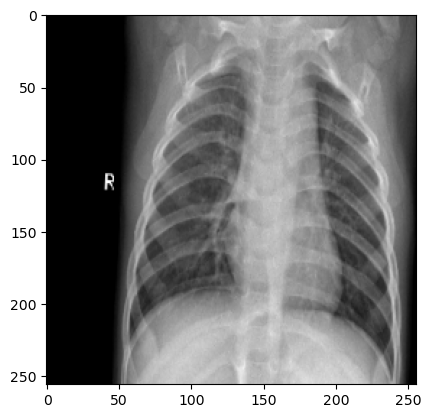

In [14]:
# Previewing sample image from training set
example_img = train_images[8]
plt.imshow(example_img)
print(train_labels[8])

From the image above, we can see this an example of a individual without pneumonia. 

1.0


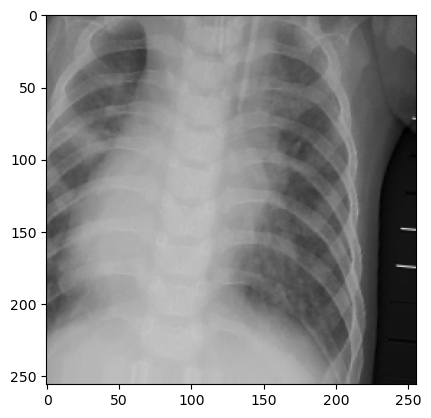

In [16]:
# Previewing sample image from training set
example_img_pne = train_images[2]
plt.imshow(example_img_pne)
print(train_labels[2])

From the image above, we can see this an example of a individual with pneumonia. 

### Class Distribution

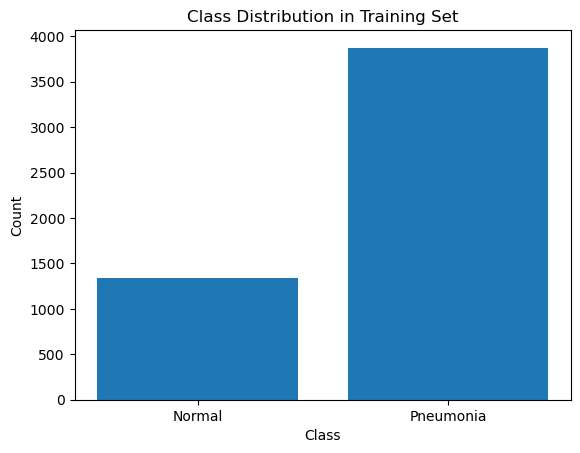

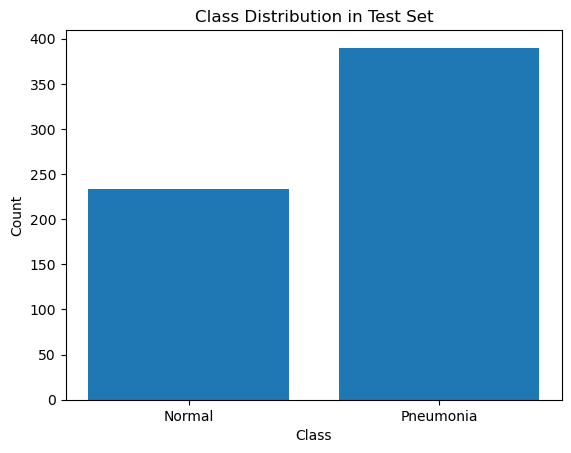

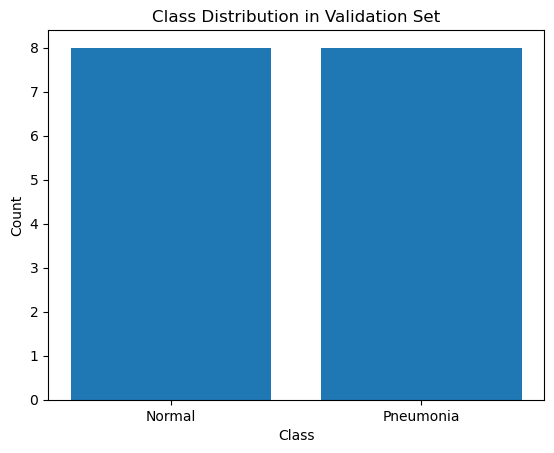

In [17]:
# Get class counts for each set
train_class_counts = np.unique(train_labels, return_counts=True)
test_class_counts = np.unique(test_labels, return_counts=True)
val_class_counts = np.unique(val_labels, return_counts=True)

# Define class labels
class_labels = {0: 'Normal', 1: 'Pneumonia'}

# Plot class distribution
def plot_class_distribution(class_counts, dataset):
    classes, counts = class_counts
    plt.bar(classes, counts)
    plt.title(f'Class Distribution in {dataset} Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(list(class_labels.keys()), [class_labels[c] for c in classes])  # Set x-axis ticks with labels
    plt.show()

# Plot for training set
plot_class_distribution(train_class_counts, 'Training')

# Plot for test set
plot_class_distribution(test_class_counts, 'Test')

# Plot for validation set
plot_class_distribution(val_class_counts, 'Validation')

Looking at the whole dataset, there is a total of 5856 images. As mentioned previously, the training set contains 5216 images, the validation set contains 16 images and the test set contains 624 images. 

- The training set has 3875 images labeled with pneumonia while having 1341 labeled as normal/without pneumonia. This image set seems to have an imbalanced class distribution since there are a long more images with pneumonia. This class imbalance could affect the model's performance and ability to generalize over the data. 
- The validation set has small number of images for both classes with 8 images labeled with pneumonia while having 8 labeled as normal/without pneumonia. 
- The test set has 390 images labeled with pneumonia while having 234 labeled as normal/without pneumonia. This image appears to have a more balanced distribution in comparison to the training set. Even though the the pneumonia images count is still higher than the images without pneumonia, the difference is not as vast as the training set. 

## Data Modeling
### Building a Convolutional Neural Network Model

For pneumonia classficiation I will be building a convolutional neural network (CNN) model. I'll start with a baseline simple CNN and then based on the results, I plan to adjust and iterate as needed to find the optimal best performing model. First I plan to test these models on a smaller subset of the training data for speed of runtimes. After the best model is determined, the whole dataset will be utilized. 

Metrics I will be looking at will include accuracy and recall of the model. 

In [18]:
from sklearn.model_selection import train_test_split

# Set the seed for reproducibility
np.random.seed(42)

# Define the percentage of the original training set to use
percentage_to_use = 0.2 

# Split the original training set into a smaller subset
sample_train_images, _, sample_train_labels, _ = train_test_split(
    train_images, train_labels, 
    train_size=percentage_to_use, 
    stratify=train_labels,  # Maintain class distribution
    random_state=42   # Set random seed for reproducibility
)

# Print the shape of the new subset
print("Sample Train Images Shape:", sample_train_images.shape)
print("Sample Train Labels Shape:", sample_train_labels.shape)


Sample Train Images Shape: (1043, 256, 256, 3)
Sample Train Labels Shape: (1043,)


In [19]:
# Define a function to plot training and validation curves
def plot_curves(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Define a function to get evaluation metrics
def get_evaluation_metrics(model):

    # Evaluate the model 
    test_evaluation_results = model.evaluate(test_images, test_labels)
    train_evaluation_results = model.evaluate(sample_train_images, sample_train_labels)

    # Print all evaluation results
    print("Test Evaluation Results:", test_evaluation_results)
    print("Train Evaluation Results:", train_evaluation_results)

    # Access specific values
    test_loss = test_evaluation_results[0]
    test_acc = test_evaluation_results[1]
    test_recall = test_evaluation_results[2]
    train_loss = train_evaluation_results[0]
    train_acc = train_evaluation_results[1]
    train_recall = train_evaluation_results[2]


    # Print specific values
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_acc)
    print("Test Recall:", test_recall)
    print("Train Loss:", train_loss)
    print("Train Accuracy:", train_acc)
    print("Train Recall:", train_recall)

### Baseline Model 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 16)      1168      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        2320      
                                                                 
 flatten_1 (Flatten)         (None, 57600)            

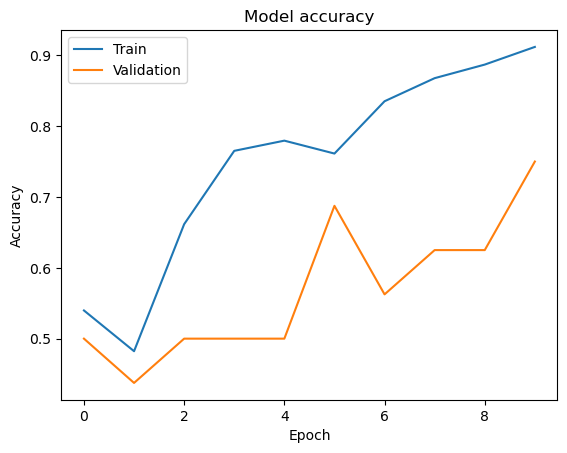

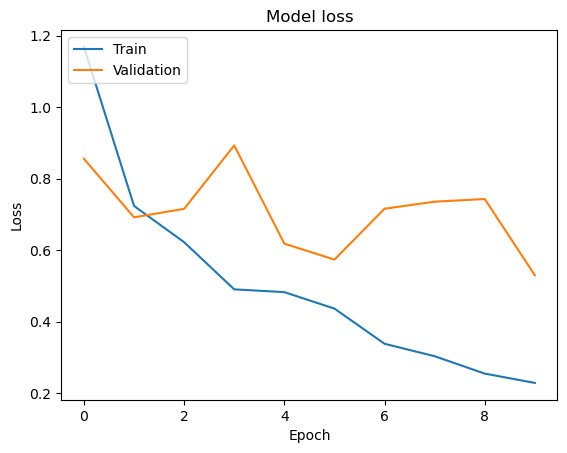

In [22]:
# cnn baseline model

# Set the seed for reproducibility
np.random.seed(42)

cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters= 8, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(16, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(16, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

# Compiling model with following parameters
cnn_model.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model.summary()

# Balancing class weights to account for class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}


# Fit and train the model 
history = cnn_model.fit(sample_train_images, sample_train_labels,
                        epochs=10,
                        batch_size=128, 
                        class_weight=class_weights_dict, 
                        validation_data=(val_images, val_labels)   
                       )

# Evaluate the model 
get_evaluation_metrics(cnn_model)

# Viewing Results 
plot_curves(history)

Looking at the baseline CNN model:

- Test Loss: 0.4282
- Test Accuracy: 0.8365
- Test Recall: 0.8359
- Train Loss: 0.2443
- Train Accuracy: 0.8984
- Train Recall: 0.8684


Overall the baseline model performed well with accuracy and recall of both training and test sets over 80%.  The model performed slightly better in both recall and accuracy on the training set indicating slight overfitting. Model performance did not get past 90% so improvement can still be achieved with this model. 

### CNN Model 2

With the second model, I plan to increase the number of filters in the convolutional layers to introduce more complexity to see if performance can be improved.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 flatten_2 (Flatten)         (None, 115200)           

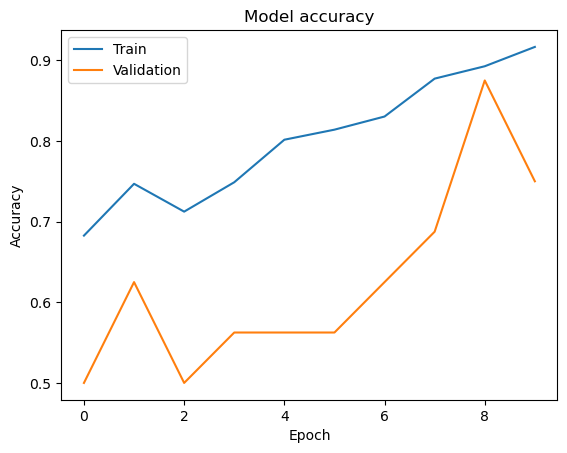

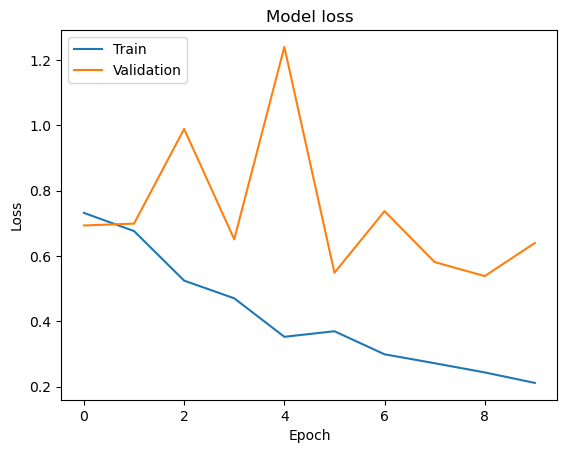

In [23]:
# CNN model 2
# increases number of filters to add complexity, only increased the conv2d layers

# Set the seed for reproducibility
np.random.seed(42)

cnn_model2 = models.Sequential()
cnn_model2.add(layers.Conv2D(filters= 16, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model2.add(layers.MaxPooling2D((2, 2)))
cnn_model2.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model2.add(layers.Flatten())
cnn_model2.add(layers.Dense(16, activation='relu'))
cnn_model2.add(layers.Dense(1, activation='sigmoid'))

# Compiling model with following parameters
cnn_model2.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model2.summary()

# Balancing class weights to account for class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}


# Fit and train the model 
history = cnn_model2.fit(sample_train_images, sample_train_labels,
                        epochs=10,
                        batch_size=128, 
                        class_weight=class_weights_dict, 
                        validation_data=(val_images, val_labels)   
                       )

# Evaluate the model 
get_evaluation_metrics(cnn_model2)

# Viewing Results 
plot_curves(history)

Looking at the second CNN model:

- Test Loss: 0.5536
- Test Accuracy: 0.7965
- Test Recall: 0.8205
- Train Loss: 0.2581
- Train Accuracy: 0.9003
- Train Recall: 0.8671


Test performance slightly decreased on this model while training performance slightly increased indicating an increase in overfitting. 

### Model 3 : Adjusting learning rate

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 flatten_5 (Flatten)         (None, 115200)           

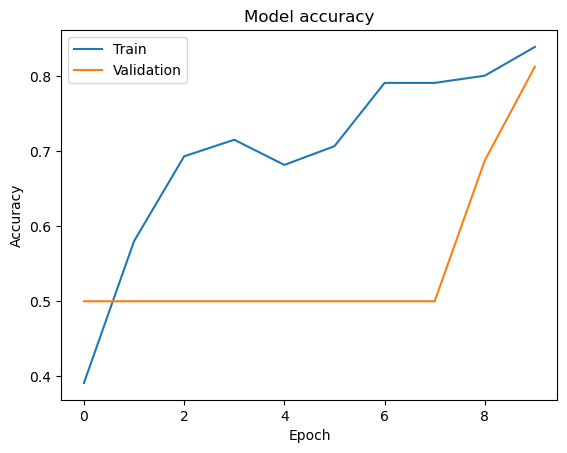

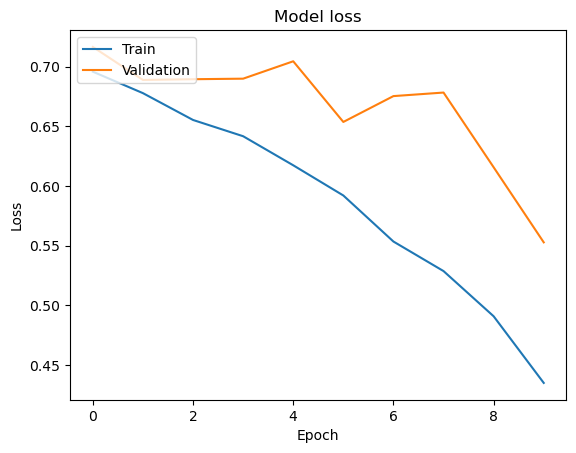

In [27]:
# CNN model 3
# increases number of filters to add complexity, only increased the conv2d layers
# Adjusted learning rate to 0.0001

# Set the seed for reproducibility
np.random.seed(42)

cnn_model3 = models.Sequential()
cnn_model3.add(layers.Conv2D(filters= 16, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model3.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model3.add(layers.MaxPooling2D((2, 2)))
cnn_model3.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model3.add(layers.Flatten())
cnn_model3.add(layers.Dense(16, activation='relu'))
cnn_model3.add(layers.Dense(1, activation='sigmoid'))

# Compiling model with following parameters
optimizer = optimizers.Adam(learning_rate=0.0001)
cnn_model3.compile(optimizer=optimizer,
                loss='binary_crossentropy', 
                metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model3.summary()

# Balancing class weights to account for class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}


# Fit and train the model 
history = cnn_model3.fit(sample_train_images, sample_train_labels,
                        epochs=10,
                        batch_size=128, 
                        class_weight=class_weights_dict, 
                        validation_data=(val_images, val_labels)   
                       )

# Evaluate the model 
get_evaluation_metrics(cnn_model3)

# Viewing Results 
plot_curves(history)

Looking at the third CNN model:

- Test Loss: 0.5612
- Test Accuracy: 0.7179
- Test Recall: 0.6564
- Train Loss: 0.4060
- Train Accuracy: 0.8619
- Train Recall: 0.8619


With adjusting the learning rate to 0.0001, overall model performance decreases with the exception of training recall which stayed about the same. Training accuracy was 0.8619 while test accuracy was 0.7179 showing model was overfitting. 

### Model 3 with adjusted learning rate of 0.001
### Top 3 model 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 flatten_6 (Flatten)         (None, 115200)           

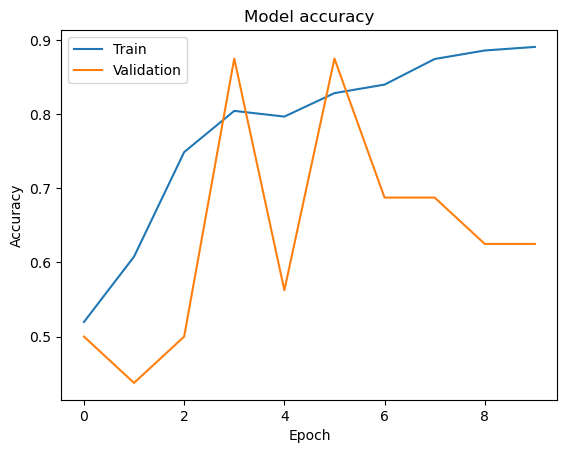

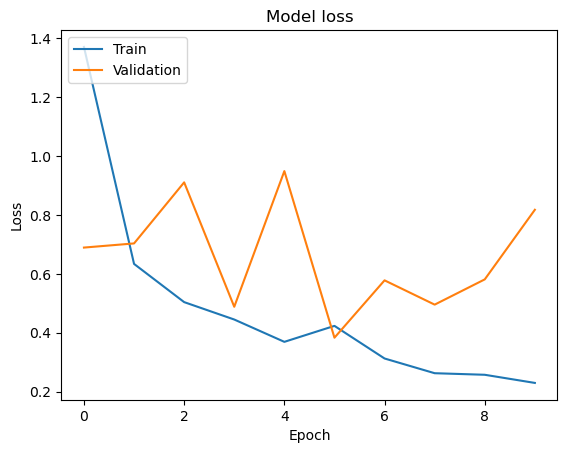

In [28]:
# CNN model 3
# Adjusted learning rate to 0.001 from previous model

# Set the seed for reproducibility
np.random.seed(42)

cnn_model3 = models.Sequential()
cnn_model3.add(layers.Conv2D(filters= 16, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model3.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model3.add(layers.MaxPooling2D((2, 2)))
cnn_model3.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model3.add(layers.Flatten())
cnn_model3.add(layers.Dense(16, activation='relu'))
cnn_model3.add(layers.Dense(1, activation='sigmoid'))

# Compiling model with following parameters
optimizer = optimizers.Adam(learning_rate=0.001)
cnn_model3.compile(optimizer=optimizer,
                loss='binary_crossentropy', 
                metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model3.summary()

# Balancing class weights to account for class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}


# Fit and train the model 
history = cnn_model3.fit(sample_train_images, sample_train_labels,
                        epochs=10,
                        batch_size=128, 
                        class_weight=class_weights_dict, 
                        validation_data=(val_images, val_labels)   
                       )

# Evaluate the model 
get_evaluation_metrics(cnn_model3)

# Viewing Results 
plot_curves(history)

Looking at the third CNN model with the adjusted learning rate of 0.001:

- Test Loss: 0.4841
- Test Accuracy: 0.8029
- Test Recall: 0.9205
- Train Loss: 0.1956
- Train Accuracy: 0.9329
- Train Recall: 0.9381


With adjusting the learning rate to 0.001, overall model performance increased form previous model but test accuracy was still slightly lower than baseline model. Train accuracy improved past baseline. Both train and test recall improved past baseline model.

### Model 4 with learning rate 0.001 and L2 regularization of 0.01

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 flatten_7 (Flatten)         (None, 115200)           

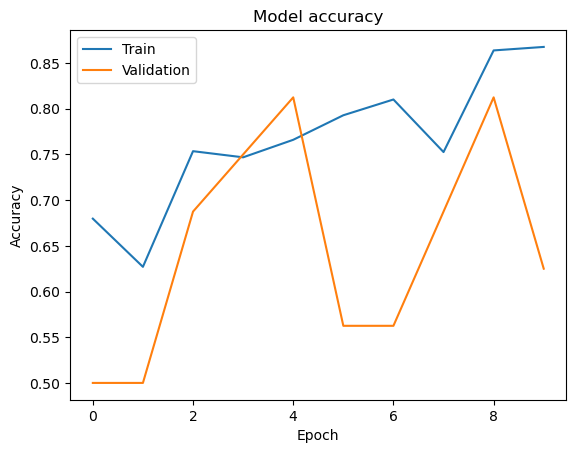

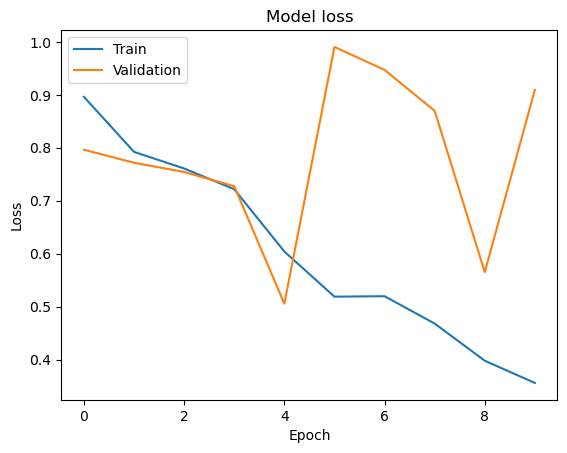

In [30]:
# CNN model 4 -- > added the L2 regularization
# increases number of filters to add complexity, only increased the conv2d layers from baseline model
# Learning rate to 0.001
# Adding L2 regularization to dense layers (strength of 0.01)

# Set the seed for reproducibility
np.random.seed(42)

cnn_model4 = models.Sequential()
cnn_model4.add(layers.Conv2D(filters= 16, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model4.add(layers.MaxPooling2D((2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model4.add(layers.Flatten())
cnn_model4.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model4.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

# Compiling model with following parameters
optimizer = optimizers.Adam(learning_rate=0.001)
cnn_model4.compile(optimizer=optimizer,
                loss='binary_crossentropy', 
                metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model4.summary()

# Balancing class weights to account for class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}


# Fit and train the model 
history = cnn_model4.fit(sample_train_images, sample_train_labels,
                        epochs=10,
                        batch_size=128, 
                        class_weight=class_weights_dict, 
                        validation_data=(val_images, val_labels)   
                       )

# Evaluate the model 
get_evaluation_metrics(cnn_model4)

# Viewing Results 
plot_curves(history)

L2 Regularization was added to the model to account for the slight overfitting. Model saw slight decrease in performance in both test accuracy and test recall and drops in train accuracy and train recall. 

- Test Loss: 0.6324442028999329
- Test Accuracy: 0.7836538553237915
- Test Recall: 0.8769230842590332
- Train Loss: 0.3406412601470947
- Train Accuracy: 0.8859060406684875
- Train Recall: 0.8529032468795776

### Model 4 L2 reg strength of 0.1 (top 3 model)

### Best Model similar to baseline model performance 

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 flatten_8 (Flatten)         (None, 115200)           

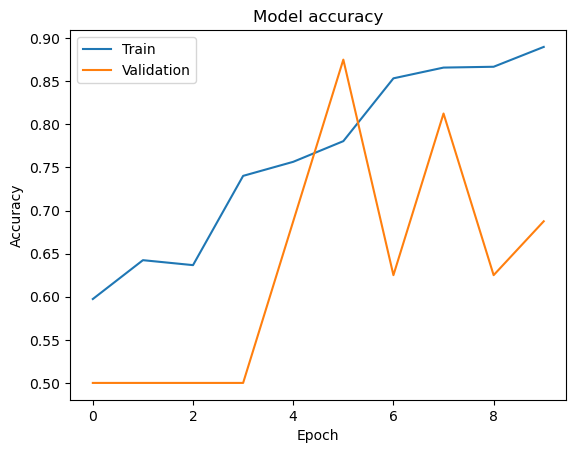

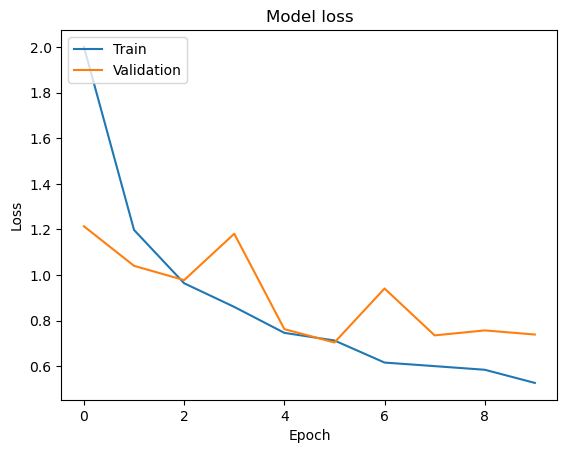

In [31]:
# CNN model  --> only adjustment made was increase L2 strengnth to 0.1
# increases number of filters to add complexity, only increased the conv2d layers
# Adjusted learning rate to 0.001
# Adding L2 regularization to dense layers

# Set the seed for reproducibility
np.random.seed(42)

cnn_model4 = models.Sequential()
cnn_model4.add(layers.Conv2D(filters= 16, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model4.add(layers.MaxPooling2D((2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model4.add(layers.Flatten())
cnn_model4.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
cnn_model4.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.1)))

# Compiling model with following parameters
optimizer = optimizers.Adam(learning_rate=0.001)
cnn_model4.compile(optimizer=optimizer,
                loss='binary_crossentropy', 
                metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model4.summary()

# Balancing class weights to account for class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}


# Fit and train the model 
history = cnn_model4.fit(sample_train_images, sample_train_labels,
                        epochs=10,
                        batch_size=128, 
                        class_weight=class_weights_dict, 
                        validation_data=(val_images, val_labels)   
                       )

# Evaluate the model 
get_evaluation_metrics(cnn_model4)

# Viewing Results 
plot_curves(history)

Looking at this model's performance, this has been one of the best performing models. Test accuracy has been one of the highest (outside of the baseline) while test recall has also performed pretty well. 

- Test Loss: 0.6956539750099182
- Test Accuracy: 0.8333333134651184
- Test Recall: 0.8307692408561707
- Train Loss: 0.46221601963043213
- Train Accuracy: 0.9127516746520996
- Train Recall: 0.8954838514328003

### Model 4 with L2 of 0.001

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 flatten_9 (Flatten)         (None, 115200)           

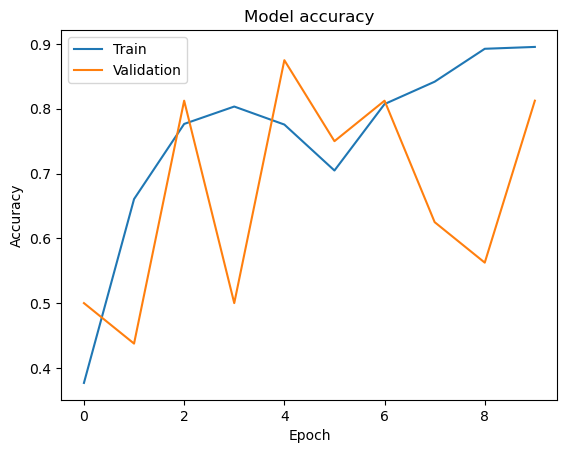

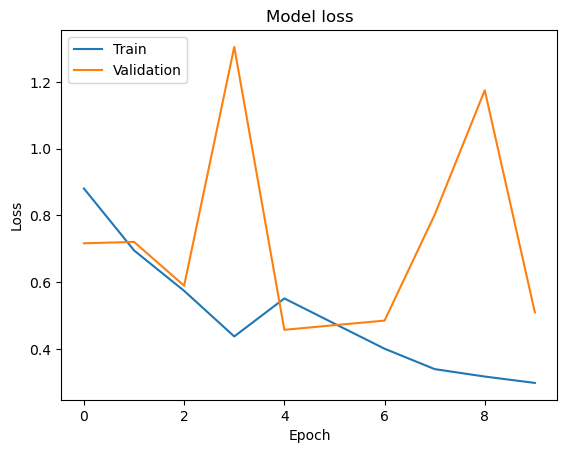

In [32]:
# CNN model 4 --> same model but lowered L2 strength to 0.001 
# increases number of filters to add complexity, only increased the conv2d layers
# learning rate to 0.001
# Adding L2 regularization to dense layers

# Set the seed for reproducibility
np.random.seed(42)

cnn_model4 = models.Sequential()
cnn_model4.add(layers.Conv2D(filters= 16, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model4.add(layers.MaxPooling2D((2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model4.add(layers.Flatten())
cnn_model4.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
cnn_model4.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))

# Compiling model with following parameters
optimizer = optimizers.Adam(learning_rate=0.001)
cnn_model4.compile(optimizer=optimizer,
                loss='binary_crossentropy', 
                metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model4.summary()

# Balancing class weights to account for class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}


# Fit and train the model 
history = cnn_model4.fit(sample_train_images, sample_train_labels,
                        epochs=10,
                        batch_size=128, 
                        class_weight=class_weights_dict, 
                        validation_data=(val_images, val_labels)   
                       )

# Evaluate the model 
get_evaluation_metrics(cnn_model4)

# Viewing Results 
plot_curves(history)

Looking at this model's performance, test and train accuracy and recall all decreased and awere actually lower than the baseline model, however test and train accuracy were very close in performance indicating that the model is not overfitting. 
- Test Loss: 0.7283
- Test Accuracy: 0.76603
- Test Recall: 0.6795
- Train Loss: 0.5055
- Train Accuracy: 0.7862
- Train Recall: 0.7123

### Model 4 L2 0.1 with 20 epochs (top 3 model)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 flatten_10 (Flatten)        (None, 115200)          

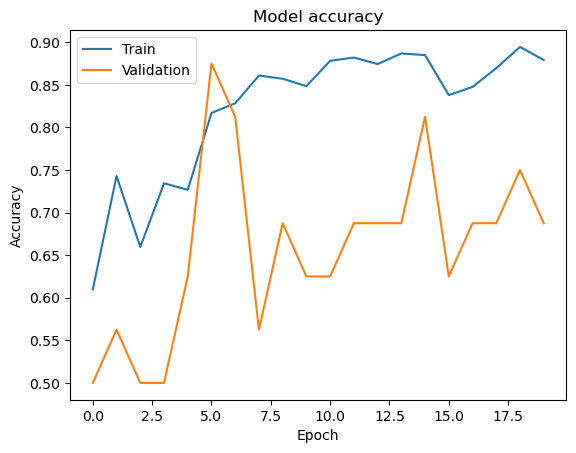

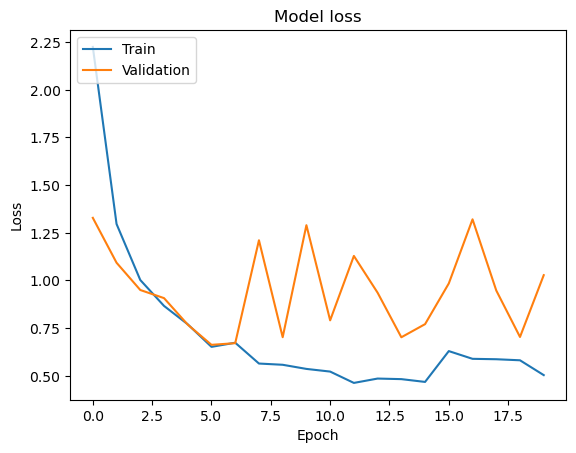

In [33]:
# CNN model 4 --> with 20 20 epochs (one of the best 3 models)
# learning rate to 0.001
# Adjusted L2 regularization to back ton 0.1 

# Set the seed for reproducibility
np.random.seed(42)

cnn_model4 = models.Sequential()
cnn_model4.add(layers.Conv2D(filters= 16, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model4.add(layers.MaxPooling2D((2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model4.add(layers.Flatten())
cnn_model4.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
cnn_model4.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.1)))

# Compiling model with following parameters
optimizer = optimizers.Adam(learning_rate=0.001)
cnn_model4.compile(optimizer=optimizer,
                loss='binary_crossentropy', 
                metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model4.summary()

# Balancing class weights to account for class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}


# Fit and train the model 
history = cnn_model4.fit(sample_train_images, sample_train_labels,
                        epochs=20,
                        batch_size=128, 
                        class_weight=class_weights_dict, 
                        validation_data=(val_images, val_labels)   
                       )

# Evaluate the model 
get_evaluation_metrics(cnn_model4)

# Viewing Results 
plot_curves(history)

After adjusting the L2 strength back to 0.1 and icnreasing epochs, model performance did improve in terms of test accuracy and recall and train accuracy and recall. Train accuracy was higher than test accuracy leading to the model overfitting, however test recall and train recall were closer.

- Test Loss: 0.6921713352203369
- Test Accuracy: 0.8092948794364929
- Test Recall: 0.928205132484436
- Train Loss: 0.4451564848423004
- Train Accuracy: 0.9108341336250305
- Train Recall: 0.9509677290916443

### Model 4 L2 0.1 with 20 epochs and increased filters 

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 flatten_11 (Flatten)        (None, 230400)          

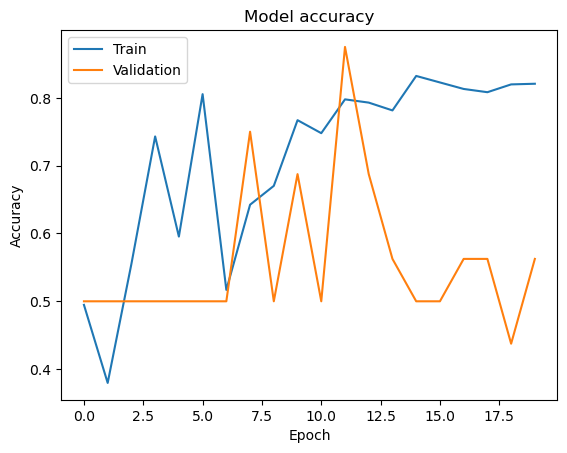

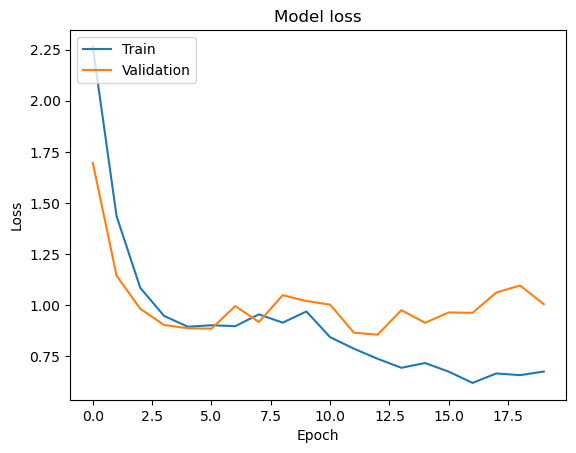

In [34]:
# CNN model 4
# filters increase in convolutional layers from 16 to 32, and 32 to 64 from previousl model

# Set the seed for reproducibility
np.random.seed(42)

cnn_model4 = models.Sequential()
cnn_model4.add(layers.Conv2D(filters= 32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model4.add(layers.MaxPooling2D((2, 2)))
cnn_model4.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model4.add(layers.Flatten())
cnn_model4.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
cnn_model4.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.1)))

# Compiling model with following parameters
optimizer = optimizers.Adam(learning_rate=0.001)
cnn_model4.compile(optimizer=optimizer,
                loss='binary_crossentropy', 
                metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model4.summary()

# Balancing class weights to account for class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}


# Fit and train the model 
history = cnn_model4.fit(sample_train_images, sample_train_labels,
                        epochs=20,
                        batch_size=128, 
                        class_weight=class_weights_dict, 
                        validation_data=(val_images, val_labels)   
                       )

# Evaluate the model 
get_evaluation_metrics(cnn_model4)

# Viewing Results 
plot_curves(history)

With filters increased there was a decrease in all around performance and an increase in the model overfitting. 

- Test Loss: 1.0436
- Test Accuracy: 0.6731
- Test Recall: 0.7846
- Train Loss: 0.7141
- Train Accuracy: 0.8284
- Train Recall: 0.7806

### Model 4 L2 0.1 with 20 epochs and additional conv2d layer

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 30, 30, 32)      

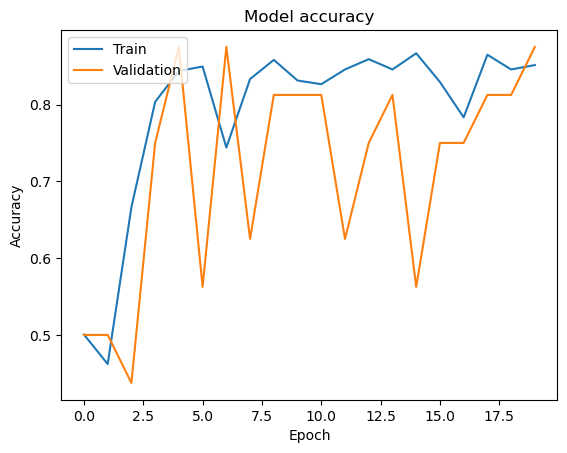

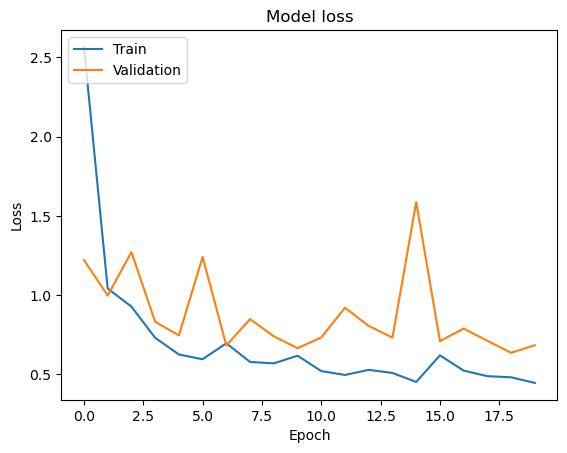

In [35]:
# CNN model 4
# Filters reduced back to 16 and 32 but one additiona conv2d layer and pooling layer added

# Set the seed for reproducibility
np.random.seed(42)

cnn_model4 = models.Sequential()
cnn_model4.add(layers.Conv2D(filters= 16, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model4.add(layers.MaxPooling2D((2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model4.add(layers.MaxPooling2D((2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model4.add(layers.Flatten())
cnn_model4.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
cnn_model4.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.1)))

# Compiling model with following parameters
optimizer = optimizers.Adam(learning_rate=0.001)
cnn_model4.compile(optimizer=optimizer,
                loss='binary_crossentropy', 
                metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model4.summary()

# Balancing class weights to account for class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}


# Fit and train the model 
history = cnn_model4.fit(sample_train_images, sample_train_labels,
                        epochs=20,
                        batch_size=128, 
                        class_weight=class_weights_dict, 
                        validation_data=(val_images, val_labels)   
                       )

# Evaluate the model 
get_evaluation_metrics(cnn_model4)

# Viewing Results 
plot_curves(history)



- Test Loss: 0.6761
- Test Accuracy: 0.7804
- Test Recall: 0.7077
- Train Loss: 0.4750
- Train Accuracy: 0.8658
- Train Recall: 0.8258

### CNN model 4 best model but with epochs up to 50

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_52 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 flatten_16 (Flatten)        (None, 115200)          

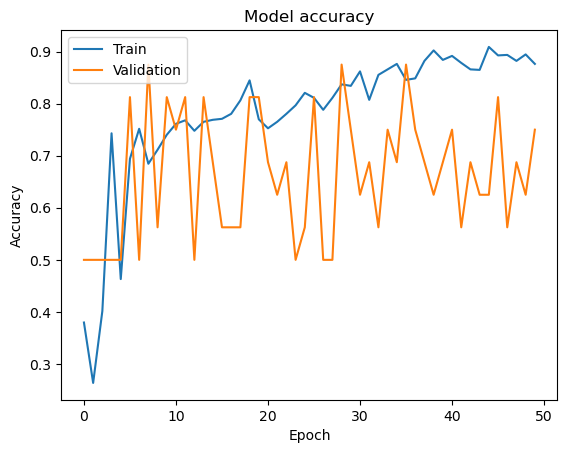

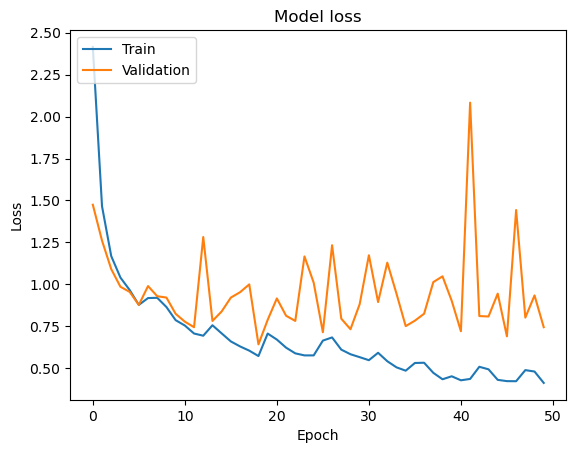

In [39]:
# CNN model 4 best model but with increased epochs to 50
# increases number of filters to add complexity, only increased the conv2d layers
# Adjusted learning rate to 0.1
# Adding L2 regularization to dense layers

# Set the seed for reproducibility
np.random.seed(42)

cnn_model4 = models.Sequential()
cnn_model4.add(layers.Conv2D(filters= 16, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model4.add(layers.MaxPooling2D((2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model4.add(layers.Flatten())
cnn_model4.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
cnn_model4.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.1)))

# Compiling model with following parameters
optimizer = optimizers.Adam(learning_rate=0.001)
cnn_model4.compile(optimizer=optimizer,
                loss='binary_crossentropy', 
                metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model4.summary()

# Balancing class weights to account for class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}


# Fit and train the model 
history = cnn_model4.fit(sample_train_images, sample_train_labels,
                        epochs=50,
                        batch_size=128, 
                        class_weight=class_weights_dict, 
                        validation_data=(val_images, val_labels)   
                       )

# Evaluate the model 
get_evaluation_metrics(cnn_model4)

# Viewing Results 
plot_curves(history)

### CNN model 4 best model but with epochs up to 50 and one extra conv2d layer
### Second best model

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_63 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_64 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 30, 30, 32)      

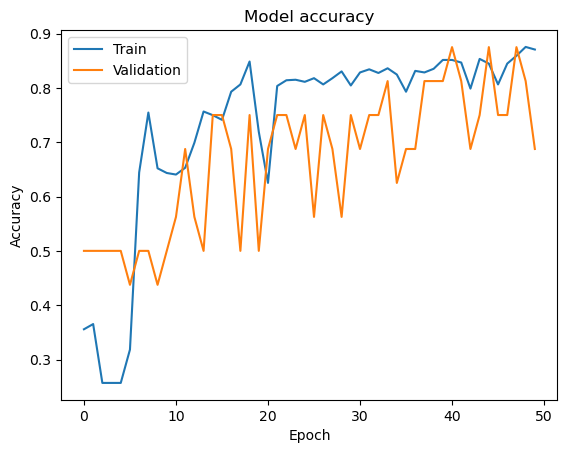

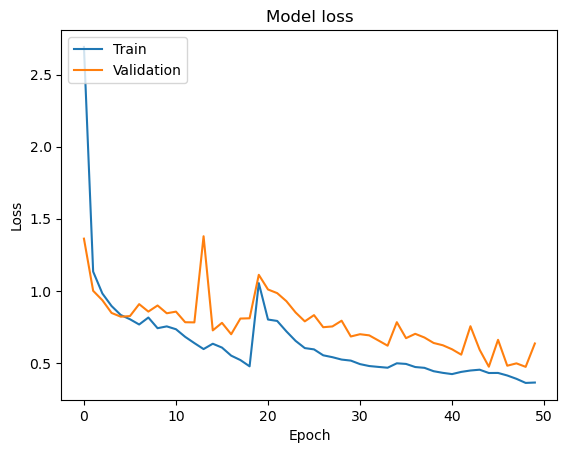

In [42]:
# CNN model 4 best model but with increased epochs to 50
# increases number of filters to add complexity, only increased the conv2d layers
# Adjusted learning rate to 0.1
# Adding L2 regularization to dense layers

# Set the seed for reproducibility
np.random.seed(42)

cnn_model4 = models.Sequential()
cnn_model4.add(layers.Conv2D(filters= 16, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model4.add(layers.MaxPooling2D((2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model4.add(layers.MaxPooling2D((2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model4.add(layers.Flatten())
cnn_model4.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
cnn_model4.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.1)))

# Compiling model with following parameters
optimizer = optimizers.Adam(learning_rate=0.001)
cnn_model4.compile(optimizer=optimizer,
                loss='binary_crossentropy', 
                metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model4.summary()

# Balancing class weights to account for class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}


# Fit and train the model 
history = cnn_model4.fit(sample_train_images, sample_train_labels,
                        epochs=50,
                        batch_size=128, 
                        class_weight=class_weights_dict, 
                        validation_data=(val_images, val_labels)   
                       )

# Evaluate the model 
get_evaluation_metrics(cnn_model4)

# Viewing Results 
plot_curves(history)

### CNN model 4 but with epochs up to 50 and one extra conv2d layer
#### adjusted model by adding early stopping to improve overfitting 

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_71 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_50 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_72 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 30, 30, 32)      

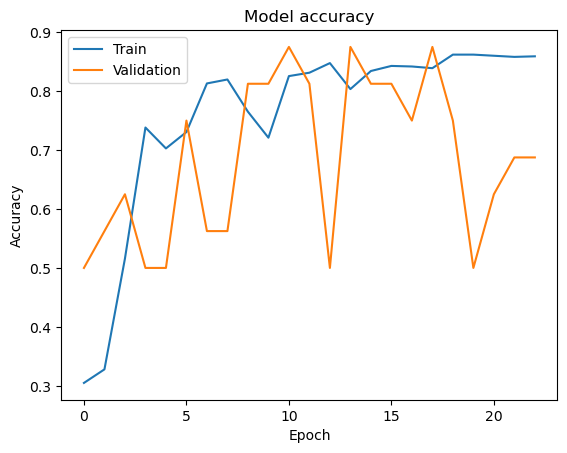

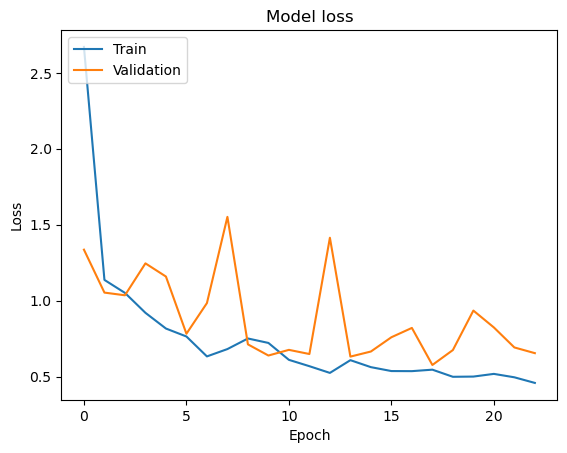

In [44]:
# CNN model 4 best model but with increased epochs to 50
# increases number of filters to add complexity, only increased the conv2d layers
# Adjusted learning rate to 0.1
# Adding L2 regularization to dense layers

# Set the seed for reproducibility
np.random.seed(42)

cnn_model4 = models.Sequential()
cnn_model4.add(layers.Conv2D(filters= 16, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model4.add(layers.MaxPooling2D((2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model4.add(layers.MaxPooling2D((2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model4.add(layers.Flatten())
cnn_model4.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
cnn_model4.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.1)))

# Compiling model with following parameters
optimizer = optimizers.Adam(learning_rate=0.001)
cnn_model4.compile(optimizer=optimizer,
                loss='binary_crossentropy', 
                metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model4.summary()

# Balancing class weights to account for class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

# Define Early Stopping callback
early_stopping = EarlyStopping(
    patience=5,  
    monitor='val_loss',  
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
)



# Fit and train the model 
history = cnn_model4.fit(sample_train_images, sample_train_labels,
                        epochs=50,
                        batch_size=128, 
                        class_weight=class_weights_dict, 
                        validation_data=(val_images, val_labels),
                        callbacks=[early_stopping], 
                       )

# Evaluate the model 
get_evaluation_metrics(cnn_model4)

# Viewing Results 
plot_curves(history)

After implementing early stopping with this model, we can see that this reduced the model overfitting from the previous model with 50 epochs, however performance is still lower than the baseline model. 

- Test Loss: 0.7574324607849121
- Test Accuracy: 0.7644230723381042
- Test Recall: 0.6794871687889099
- Train Loss: 0.5156298875808716
- Train Accuracy: 0.8648130297660828
- Train Recall: 0.8309677243232727

## Evaluation 

Looking at the modeling and models built, overall the baseline model seemed to perform the best when accounting for all metrics. With the baseline CNN model test accuracy was highest at ~84% with a test recall at ~ 84%. Train accuracy was at ~90% and train recall at ~87%. While these are slightly higher than the test metrics showing slight overfitting, this was more ideal than other models which were showing signs of higher degrees of overfitting and lower performance on test sets. 

- Test Loss: 0.4282
- Test Accuracy: 0.8365
- Test Recall: 0.8359
- Train Loss: 0.2443
- Train Accuracy: 0.8984
- Train Recall: 0.8684

## Conclusion and Recommendations 

- Healthcare providers should utilize this model as a tool for early pneumonia detection. While this model is not an official diagnostic tool for penuamonia, this model is useful for early detecton and screening. 

- Using this model, practitioner's can implement preventative health strategies to their patient population early on before disease progression and improve overall health outcomes. 

- In the context of identifying pneumonia. 

## Limitations and Future Considerations

While the model can be useful in the detection of pneumonia from chest x-ray images, the model is not perfect and does have it's limitations.

- False positives: When individuals actually have pneumonia, the model correctly identifies those indiviudals approximiately 84% of the time. With having a higher recall, there is an increased risk of incorrectly classifying indiviudals without pneumonia as having pneumonia. While there is this increased chance, having an increased risk of incorreclty identifying someone as having pneumonia is a better trade off in this situation that incorrectly labeling someone as not having pneumonia when they in fact do have pneumonia. If someone is labeled as a false positive, while it may be an inconvenience to that individual, this is better than the alternative becuase pneumonia is a serious condition that can be life threatening if left undetected and untreated. 

- Small sample size: With more data and more images to analyze, a more robust model could be utilized to increased accuracy.

- Run time/ Model complexity: As model complexity increases, this does increase the requirement for computation power and can increase model run times.



## Contact Information

- Email: ldwilker10@gmail.com

- GitHub: https://github.com/ldwilker10

- LinkedIn: https://www.linkedin.com/in/lucasdukewilkerson/